In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Cargar datos
data_path = '/Users/luissalamanca/Desktop/Duoc/Machine/ML_Proyecto_Semestral/data/03_features/engineered_data.csv'
data = pd.read_csv(data_path, sep=';')

# Separar columnas concatenadas
if len(data.columns) == 1:
    column_name = data.columns[0]
    if ',' in column_name:
        new_columns = column_name.split(',')
        data_split = data[column_name].str.split(',', expand=True)
        data_split.columns = new_columns
        for col in data_split.columns:
            data_split[col] = pd.to_numeric(data_split[col], errors='coerce')
        data = data_split

# Lista de features y target
features = [
    'EconomicEfficiency',
    'EffectivenessScore',
    'EquipmentAdvantage',
    'KillAssistRatio',
    'StealthKillsRatio'
]
X = data[features]
y = data['KDA']

# Dividir en entrenamiento/prueba (30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [3]:
pipeline_rf = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

param_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

gs_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_rf,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=1
)

# Ajustar GridSearchCV para Random Forest
gs_rf.fit(X_train, y_train)

# Mejor modelo y predicción
best_rf = gs_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Métricas
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\n=== RANDOM FOREST REGRESSOR ===")
print("Mejores hiperparámetros encontrados:")
print(gs_rf.best_params_)
print(f"R² (Coef. determinación): {r2_rf:.4f}")
print(f"MSE:  {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE:  {mae_rf:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== RANDOM FOREST REGRESSOR ===
Mejores hiperparámetros encontrados:
{'regressor__max_depth': 5, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
R² (Coef. determinación): 0.8921
MSE:  0.0786
RMSE: 0.2803
MAE:  0.1732


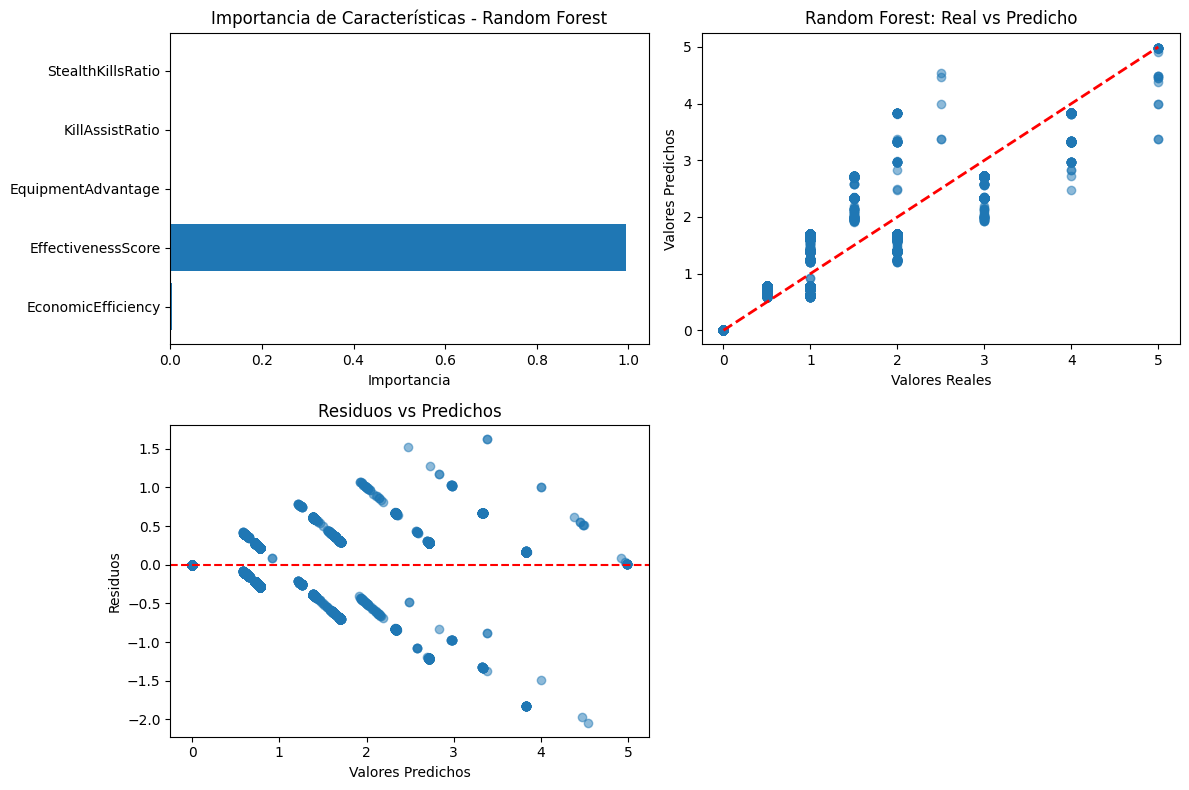

In [4]:
# Importancia de características
importances_rf = best_rf['regressor'].feature_importances_

plt.figure(figsize=(12, 8))

# Gráfico de importancia
plt.subplot(2, 2, 1)
plt.barh(features, importances_rf)
plt.xlabel('Importancia')
plt.title('Importancia de Características - Random Forest')

# Valores reales vs predichos
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Random Forest: Real vs Predicho')

# Residuos
plt.subplot(2, 2, 3)
residuos_rf = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuos_rf, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Predichos')

plt.tight_layout()
plt.show()